In [1]:
import os
import pandas as pd
import geopandas as gpd
import plotly.express as px
import ast
%pylab inline

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 40000)
pd.set_option('display.max_rows', None)

df_safegraph_poi = pd.read_csv(os.path.join('..', 'dewey_data_filtered','SafeGraph_POI_Yellowstone_200miRadius.csv.gz'))
df_safegraph_spend = pd.read_csv(os.path.join('..', 'dewey_data_filtered','SafeGraph_SPEND_Yellowstone_200miRadius.csv.gz'))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
mask = df_safegraph_poi['CITY'] == 'Cody'
df_cody_poi = df_safegraph_poi[mask]
 
if 'PLACEKEY' in df_safegraph_spend.columns:
    df_cody = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_cody_poi['PLACEKEY'])]
else:
    print("Error: DataFrame does not contain 'PLACEKEY' column.")

print(df_cody.head(10))

                PLACEKEY                        SAFEGRAPH_BRAND_IDS               BRANDS   SPEND_DATE_RANGE_START     SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT 

## Functions

In [3]:
def time_filt(df, start, end):
    datetime_start = pd.to_datetime(start)
    datetime_end = pd.to_datetime(end)
    df_copy = df.copy()
    
    df_copy['SPEND_DATE_RANGE_START'] = pd.to_datetime(df_copy['SPEND_DATE_RANGE_START'])
    df_copy['SPEND_DATE_RANGE_END'] = pd.to_datetime(df_copy['SPEND_DATE_RANGE_END'])
    
    df_filtered = df_copy[(df_copy['SPEND_DATE_RANGE_START'] >= datetime_start) &
                                 (df_copy['SPEND_DATE_RANGE_END'] <= datetime_end)]
    
    return df_filtered


In [4]:
def percent_instate(df):
    home_city = df['CUSTOMER_HOME_CITY']
    in_state = 0
    out_state = 0

    for val in df['CUSTOMER_HOME_CITY']:
        cities = val.split(",")
        cities = cities[1::2]
        for i in cities:
            state = i.split(':')
            if(state[0].find("WY") != 1):
                count = state[1].strip("{}")
                out_state += int(count)
            else:
                count = state[1].strip("{}")
                in_state += int(count)
    
    print('Out of state: ', out_state)
    print('In state: ', in_state)
    print('Percentage out of state:', (out_state)/(in_state+out_state)*100, '%')
    
    return [in_state, out_state]

In [5]:
def percent_change_month(df):
    pct_change_month = df['SPEND_PCT_CHANGE_VS_PREV_MONTH'].dropna()
    
    sum = 0
    product = 1
    for val in pct_change_month:
        sum += val/100
        product *= val/100
    pct_change_total = (sum + product)*100
    return pct_change_total

In [6]:
def percent_change_year(df):
    pct_change_year = df['SPEND_PCT_CHANGE_VS_PREV_YEAR'].dropna()
    
    sum = 0
    product = 1
    for val in pct_change_year:
        sum += val/100
        product *= val/100
    pct_change_total = (sum + product)*100
    return pct_change_total

In [7]:
def spend_by_day(df):
    df_filtered = df.copy()

    # Convert string representations of lists in 'SPEND_BY_DAY' to actual lists
    df_filtered['SPEND_BY_DAY'] = df_filtered['SPEND_BY_DAY'].apply(ast.literal_eval)

    # Add a new column called 'DATE_OF_MONTH', as a list of integers from 1 to the end of the month (length of the 'SPEND_BY_DAY' list)
    df_filtered['DATE_OF_MONTH'] = df_filtered['SPEND_BY_DAY'].apply(lambda x: list(range(1, len(x) + 1)))

    df_spend_by_day = df_filtered.explode(['SPEND_BY_DAY', 'DATE_OF_MONTH'])

    df_spend_by_day['SPEND_BY_DAY'] = df_spend_by_day['SPEND_BY_DAY'].astype(float)
    df_spend_by_day['DATE_OF_MONTH'] = df_spend_by_day['DATE_OF_MONTH'].astype(int)

    df_spend_by_day['DATE'] = pd.to_datetime(df_spend_by_day['SPEND_DATE_RANGE_START']) + pd.to_timedelta(df_spend_by_day['DATE_OF_MONTH'] - 1, unit='D')

    df_grouped = df_spend_by_day.groupby('DATE')['SPEND_BY_DAY'].sum()

    return df_grouped

## General Cody, WY

In [20]:
df_cody_flood = time_filt(df_cody, '2022-05-01', '2022-08-01')
df_flood_spending = spend_by_day(df_cody_flood)

before_flood = df_flood_spending[33:40]
during_flood = df_flood_spending[40:47]
after_flood = df_flood_spending[47:54]
print(before_flood)
print(during_flood)
print(after_flood)

DATE
2022-06-03    12067.17
2022-06-04     6249.49
2022-06-05     7632.29
2022-06-06    18067.75
2022-06-07    12600.15
2022-06-08    16904.57
2022-06-09     9891.03
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10    13450.56
2022-06-11     8618.89
2022-06-12     8360.42
2022-06-13    28320.78
2022-06-14    15032.38
2022-06-15    13299.62
2022-06-16    12911.00
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17    14395.07
2022-06-18     7570.51
2022-06-19     9918.60
2022-06-20    10460.85
2022-06-21    32439.57
2022-06-22    13448.02
2022-06-23    12379.93
Name: SPEND_BY_DAY, dtype: float64


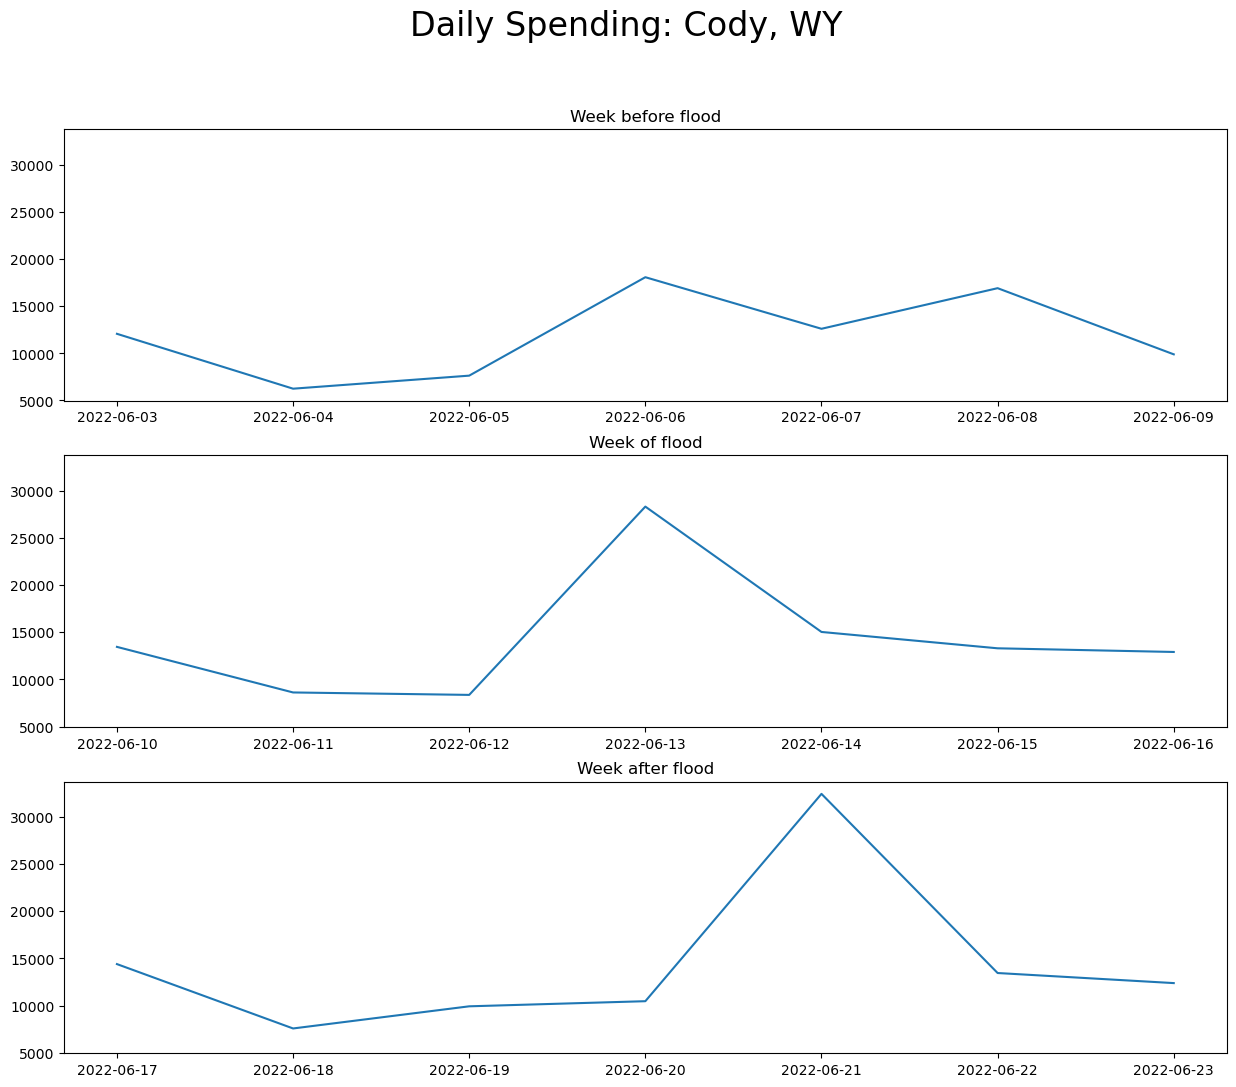

In [21]:
fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood)
ax1.set_title('Week before flood');
ax2.plot(during_flood)
ax2.set_title('Week of flood');
ax3.plot(after_flood)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending: Cody, WY', fontsize='24');

In [22]:
before_flood_start = '2022-05-01'
before_flood_end = '2022-06-01'

df_cody_before = time_filt(df_cody, before_flood_start, before_flood_end)


In [23]:
during_flood_start = '2022-06-01'
during_flood_end = '2022-07-01'

df_cody_during = time_filt(df_cody, during_flood_start, during_flood_end)

In [24]:
after_flood_start = '2022-07-01'
after_flood_end = '2022-08-01'

df_cody_after = time_filt(df_cody, after_flood_start, after_flood_end)
print(df_cody_after)

                   PLACEKEY                        SAFEGRAPH_BRAND_IDS                               BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND                  TRANSACTION_INTERMEDIARY                  SPEND_BY_TRANSACTION_INTERMEDIARY                        BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PC

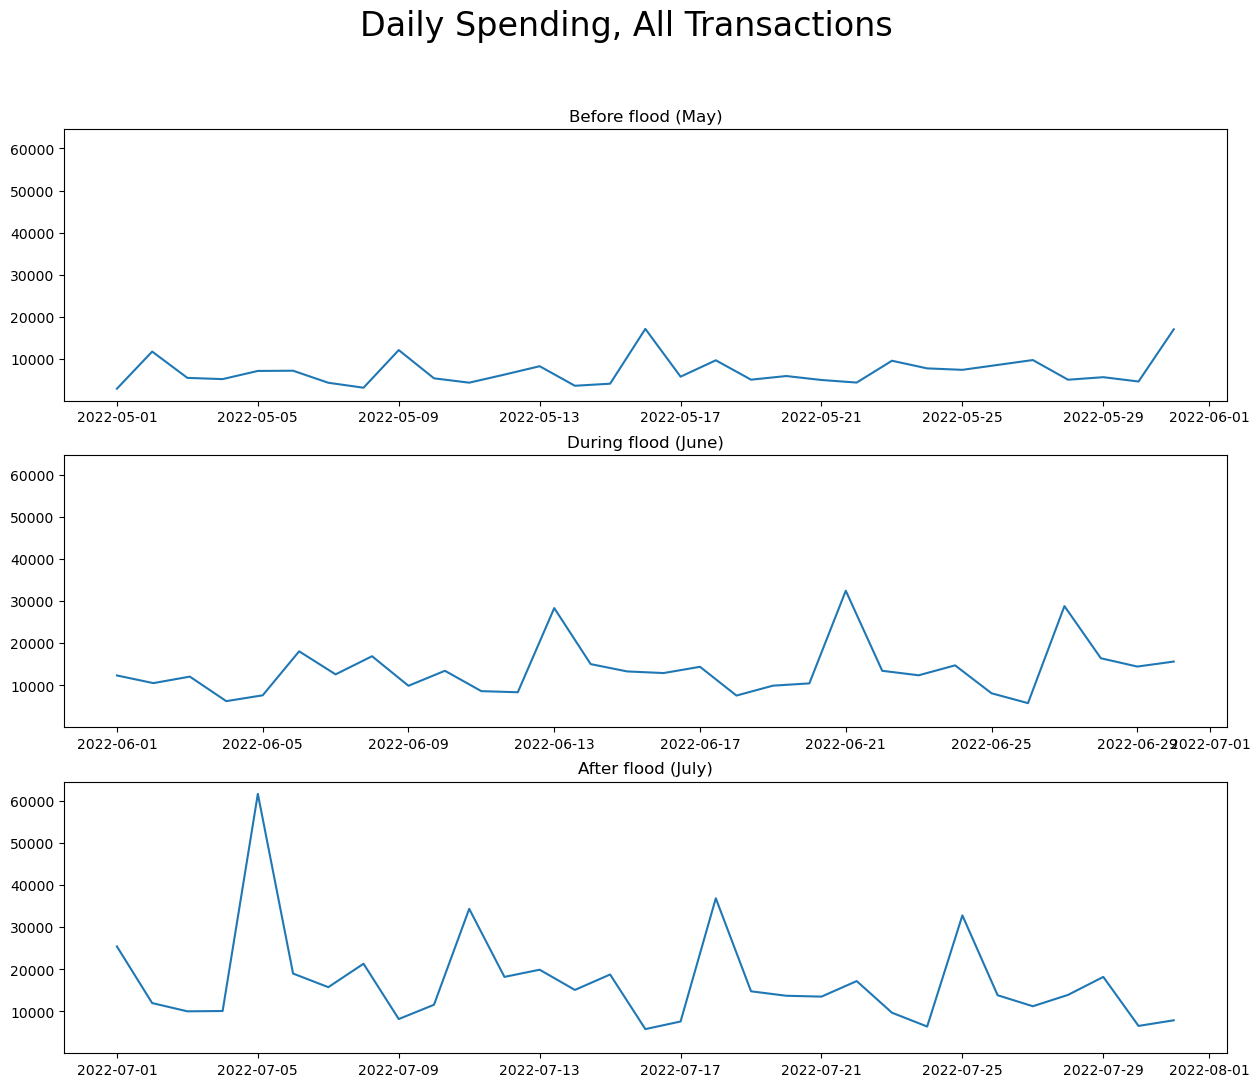

In [25]:
df_spend_before = spend_by_day(df_cody_before)
df_spend_during = spend_by_day(df_cody_during)
df_spend_after = spend_by_day(df_cody_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(df_spend_before)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, All Transactions', fontsize='24');

In [26]:
print('Percent Change April to May: ')
print(percent_change_month(df_cody_before), '%\n')

print('Percent Change May to Jume: ')
print(percent_change_month(df_cody_during), '%\n')

print('Percent Change June to July: ')
print(percent_change_month(df_cody_after), '%\n')

Percent Change April to May: 
4735.999999999998 %

Percent Change May to Jume: 
-4385900.90989364 %

Percent Change June to July: 
5794.999999999998 %



In [27]:
print('Percent Change May 2021 to May 2022: ')
print(percent_change_year(df_cody_before), '%\n')

print('Percent Change June 2021 to Jume 2022: ')
print(percent_change_year(df_cody_during), '%\n')

print('Percent Change July 2021 to July 2022: ')
print(percent_change_year(df_cody_after), '%\n')

Percent Change May 2021 to May 2022: 
1877.0 %

Percent Change June 2021 to Jume 2022: 
4454.000000000001 %

Percent Change July 2021 to July 2022: 
4714.999999999999 %



Before Flooding: 
Out of state:  2760
In state:  781
Percentage out of state: 77.94408359220559 %


During Flooding: 
Out of state:  5465
In state:  818
Percentage out of state: 86.98074168390896 %


After Flooding: 
Out of state:  5982
In state:  1783
Percentage out of state: 77.03799098518995 %




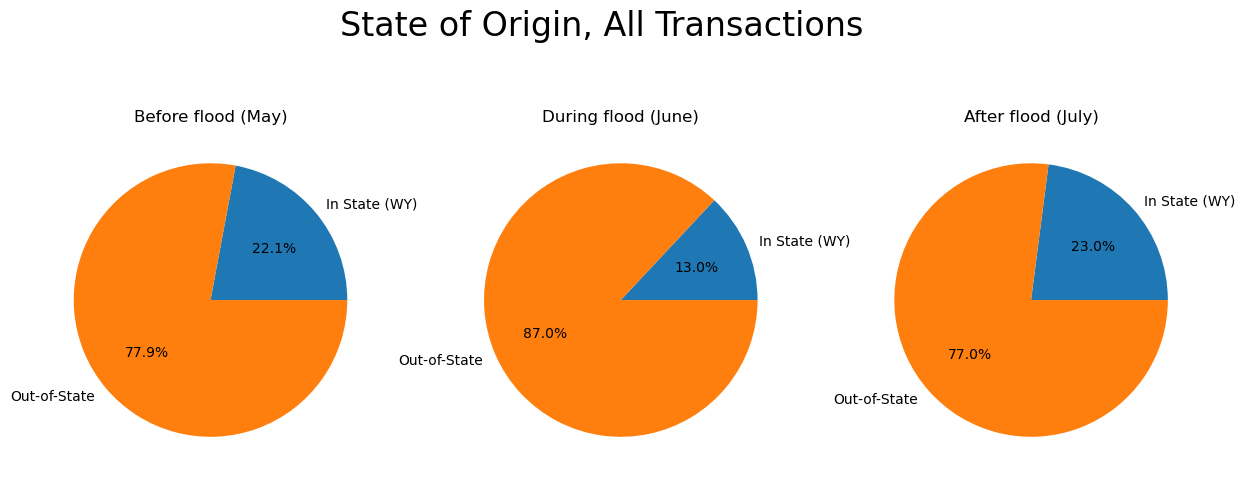

In [28]:
print('Before Flooding: ')
before = percent_instate(df_cody_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_cody_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_cody_after)
print('\n')

labels = 'In State (WY)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));
ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');

fig.suptitle('State of Origin, All Transactions', fontsize='24');

In [29]:
month = ['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', 
         '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01']

df_cody_jan = time_filt(df_cody, month[0], month[1])
df_cody_feb = time_filt(df_cody, month[1], month[2])
df_cody_mar = time_filt(df_cody, month[2], month[3])
df_cody_apr = time_filt(df_cody, month[3], month[4])
df_cody_may = time_filt(df_cody, month[4], month[5])
df_cody_jun = time_filt(df_cody, month[5], month[6])
df_cody_jul = time_filt(df_cody, month[6], month[7])
df_cody_aug = time_filt(df_cody, month[7], month[8])
df_cody_sep = time_filt(df_cody, month[8], month[9])
df_cody_oct = time_filt(df_cody, month[9], month[10])
df_cody_nov = time_filt(df_cody, month[10], month[11])
df_cody_dec = time_filt(df_cody, month[11], month[12])

month_dfs = [df_cody_jan, df_cody_feb, df_cody_mar, df_cody_apr, df_cody_may, df_cody_jun, 
             df_cody_jul, df_cody_aug, df_cody_sep, df_cody_oct, df_cody_nov, df_cody_dec]

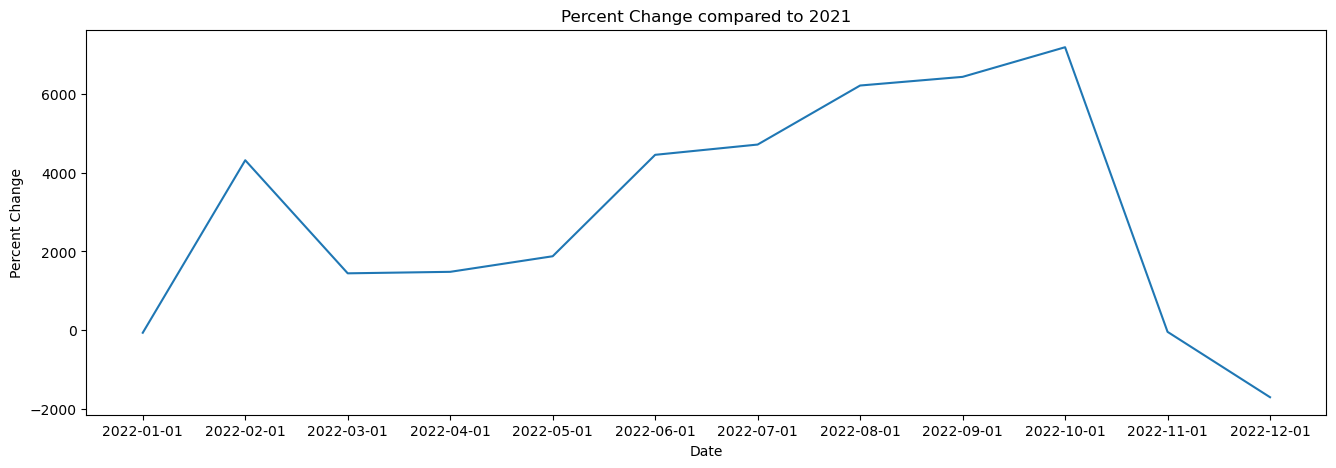

In [30]:
prev_year_pct=[]

for i in range(0, len(month_dfs)):
    prev_year_pct.append(percent_change_year(month_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

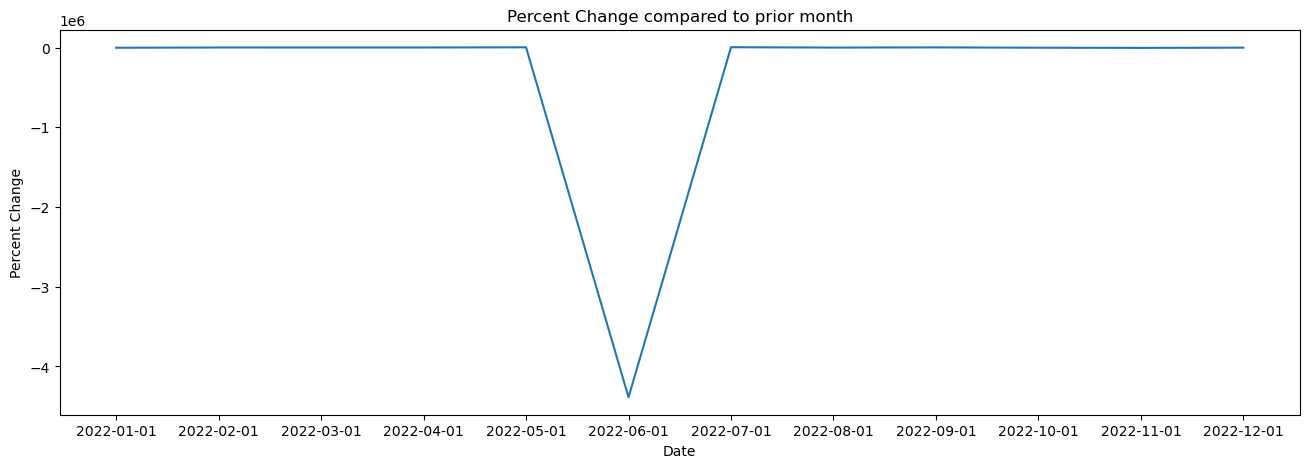

In [31]:
prev_month_pct=[]

for i in range(0, len(month_dfs)):
    prev_month_pct.append(percent_change_month(month_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Cody Accomodations

In [32]:
accomodation_naics = '721'
mask = [ str(ncode)[:3]==accomodation_naics for ncode in list(df_cody_poi['NAICS_CODE']) ]
df_hotels_pois = df_cody_poi[mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_cody_hotels = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_hotels_pois['PLACEKEY'])]

df_hotel_before = time_filt(df_cody_hotels, before_flood_start, before_flood_end)
print(df_hotel_before.head(5), '\n')

df_hotel_during = time_filt(df_cody_hotels, during_flood_start, during_flood_end)
print(df_hotel_during.head(5), '\n')

df_hotel_after = time_filt(df_cody_hotels, after_flood_start, after_flood_end)
print(df_hotel_after.head(5), '\n')

                   PLACEKEY                        SAFEGRAPH_BRAND_IDS       BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RELATED_

DATE
2022-06-03    1741.76
2022-06-04     198.78
2022-06-05     215.34
2022-06-06    1978.32
2022-06-07     722.43
2022-06-08    2375.40
2022-06-09      45.06
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10    1449.75
2022-06-11     662.27
2022-06-12    1302.79
2022-06-13    1345.18
2022-06-14    1140.84
2022-06-15    1816.82
2022-06-16     967.06
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17    1004.59
2022-06-18       0.00
2022-06-19    1184.50
2022-06-20    1025.65
2022-06-21     238.12
2022-06-22    1235.34
2022-06-23    1128.64
Name: SPEND_BY_DAY, dtype: float64


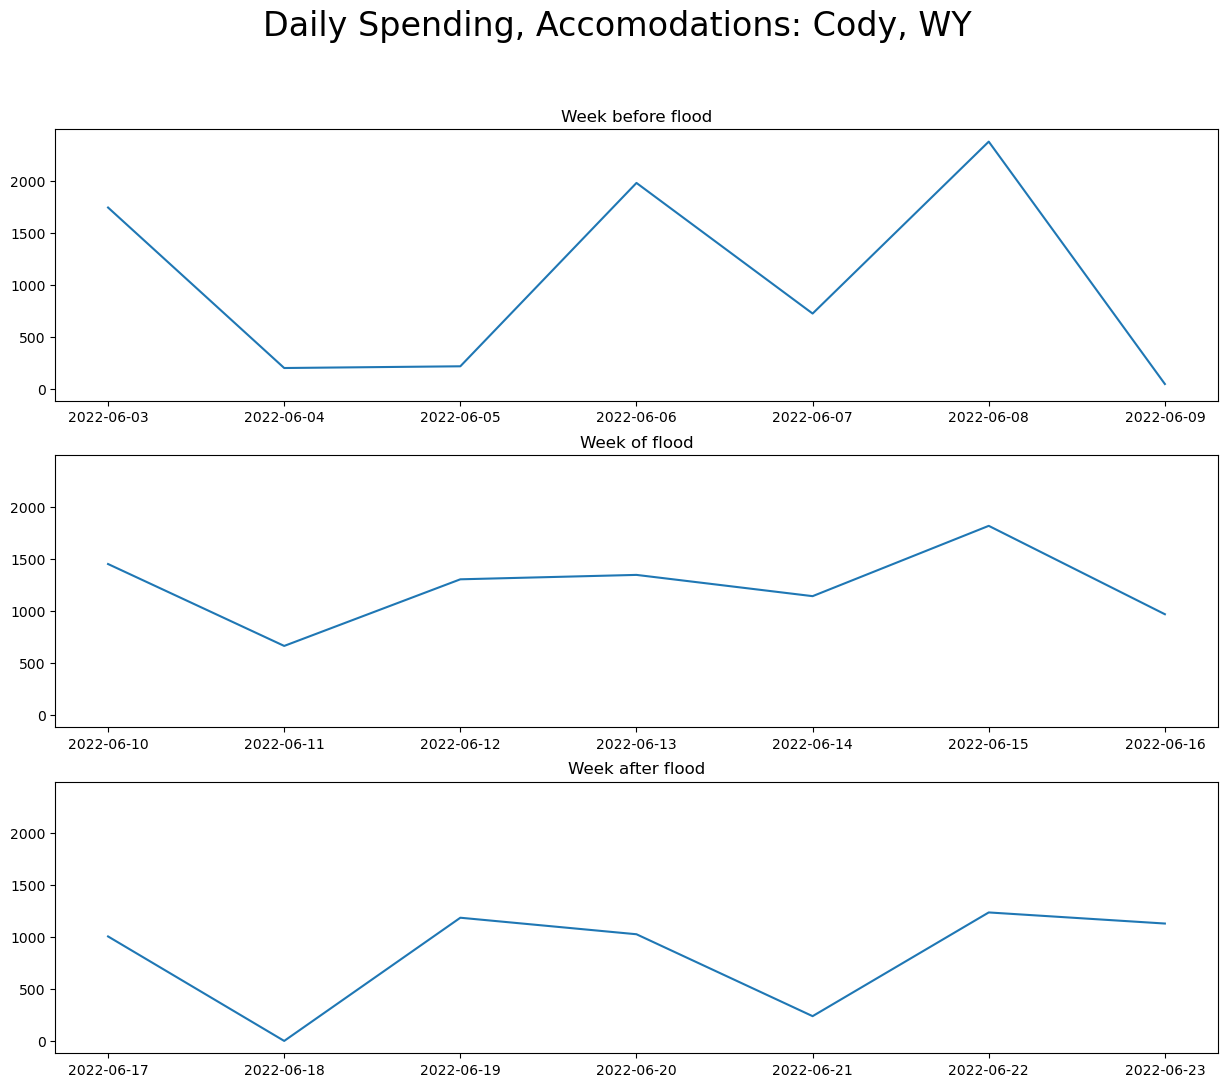

In [62]:
df_hotel_flood = time_filt(df_cody_hotels, '2022-05-01', '2022-08-01')
df_flood_spending_hotels = spend_by_day(df_hotel_flood)

before_flood_hotels = df_flood_spending_hotels[33:40]
during_flood_hotels = df_flood_spending_hotels[40:47]
after_flood_hotels = df_flood_spending_hotels[47:54]
print(before_flood_hotels)
print(during_flood_hotels)
print(after_flood_hotels)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_hotels)
ax1.set_title('Week before flood');
ax2.plot(during_flood_hotels)
ax2.set_title('Week of flood');
ax3.plot(after_flood_hotels)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Accomodations: Cody, WY', fontsize='24');

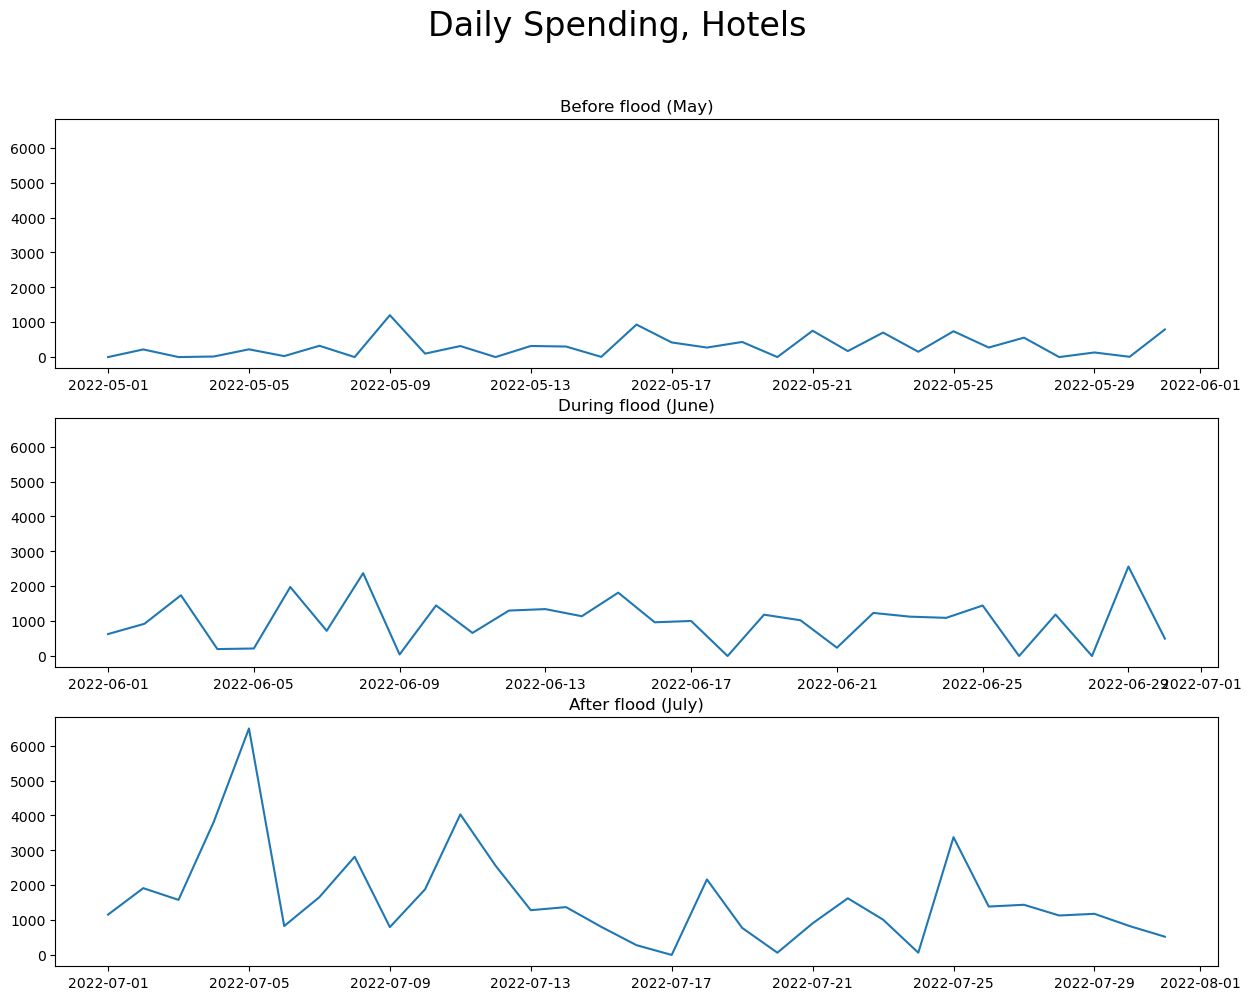

In [34]:
df_spend_before_hotel = spend_by_day(df_hotel_before)
df_spend_during_hotel = spend_by_day(df_hotel_during)
df_spend_after_hotel = spend_by_day(df_hotel_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_hotel)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_hotel)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_hotel)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Hotels', fontsize='24');

Before Flooding: 
Out of state:  92
In state:  9
Percentage out of state: 91.0891089108911 %


During Flooding: 
Out of state:  224
In state:  13
Percentage out of state: 94.51476793248945 %


After Flooding: 
Out of state:  250
In state:  10
Percentage out of state: 96.15384615384616 %




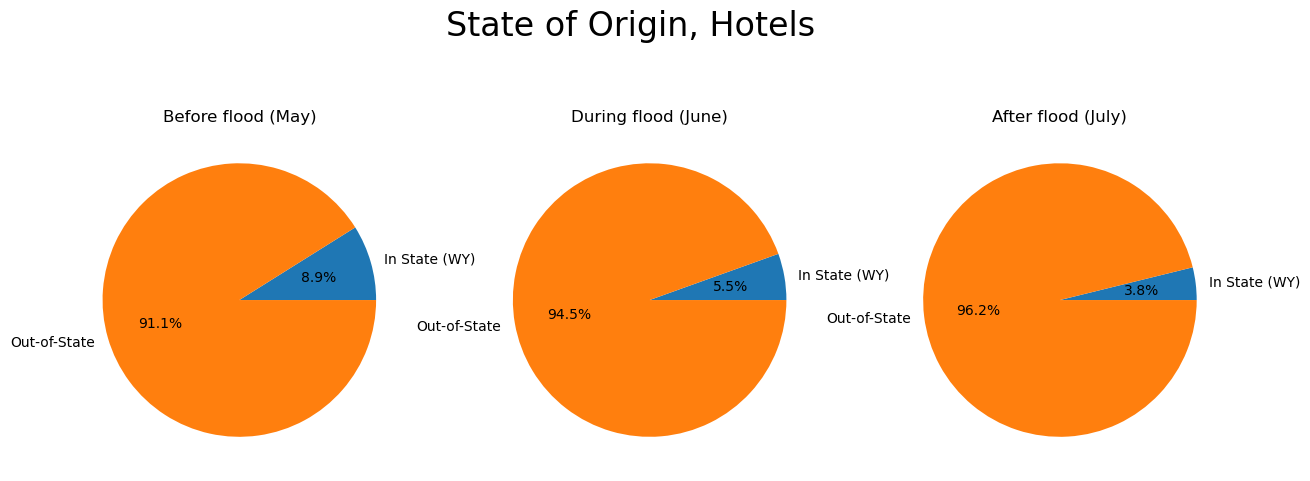

In [35]:
print('Before Flooding: ')
before = percent_instate(df_hotel_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_hotel_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_hotel_after)
print('\n')

labels = 'In State (WY)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Hotels', fontsize='24');

In [36]:
df_hotel_jan = time_filt(df_cody_hotels, month[0], month[1])
df_hotel_feb = time_filt(df_cody_hotels, month[1], month[2])
df_hotel_mar = time_filt(df_cody_hotels, month[2], month[3])
df_hotel_apr = time_filt(df_cody_hotels, month[3], month[4])
df_hotel_may = time_filt(df_cody_hotels, month[4], month[5])
df_hotel_jun = time_filt(df_cody_hotels, month[5], month[6])
df_hotel_jul = time_filt(df_cody_hotels, month[6], month[7])
df_hotel_aug = time_filt(df_cody_hotels, month[7], month[8])
df_hotel_sep = time_filt(df_cody_hotels, month[8], month[9])
df_hotel_oct = time_filt(df_cody_hotels, month[9], month[10])
df_hotel_nov = time_filt(df_cody_hotels, month[10], month[11])
df_hotel_dec = time_filt(df_cody_hotels, month[11], month[12])

hotel_dfs = [df_hotel_jan, df_hotel_feb, df_hotel_mar, df_hotel_apr, df_hotel_may, df_hotel_jun, 
             df_hotel_jul, df_hotel_aug, df_hotel_sep, df_hotel_oct, df_hotel_nov, df_hotel_dec]

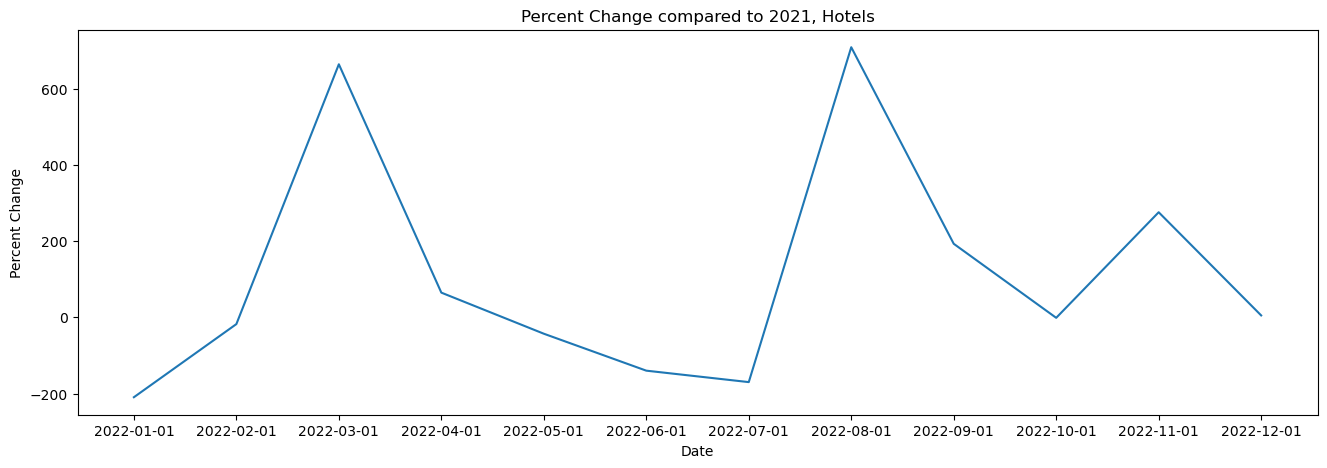

In [37]:
prev_year_pct=[]

for i in range(0, len(hotel_dfs)):
    prev_year_pct.append(percent_change_year(hotel_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Hotels');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

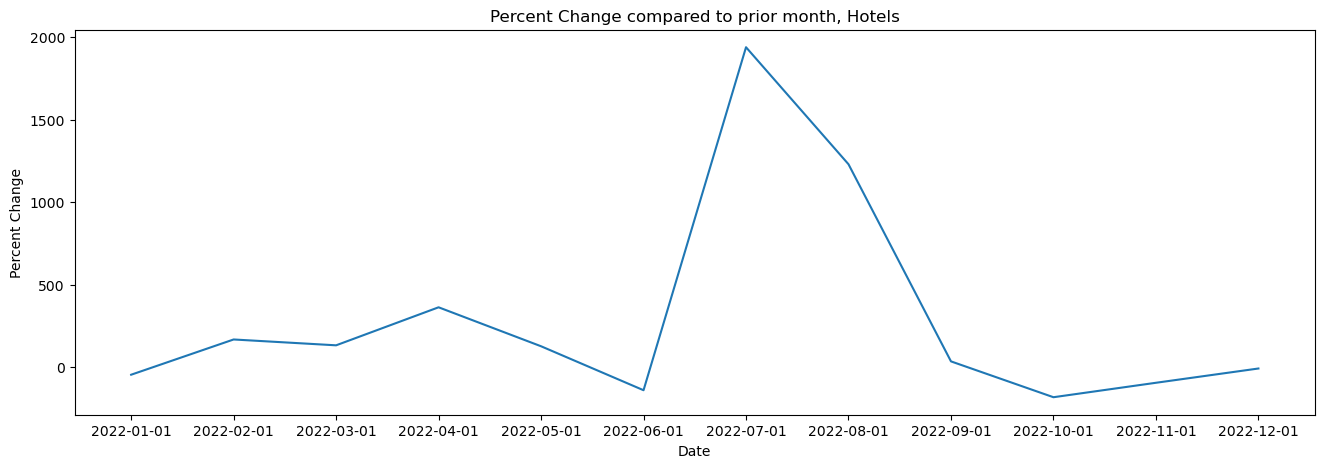

In [38]:
prev_month_pct=[]

for i in range(0, len(hotel_dfs)):
    prev_month_pct.append(percent_change_month(hotel_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Hotels');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Cody Food

In [39]:
food_naics = '722'
mask = [ str(ncode)[:3]==food_naics for ncode in list(df_cody_poi['NAICS_CODE']) ]
df_food_pois = df_cody_poi[mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_cody_food = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_food_pois['PLACEKEY'])]

df_food_before = time_filt(df_cody_food, before_flood_start, before_flood_end)
print(df_food_before.head(5), '\n')

df_food_during = time_filt(df_cody_food, during_flood_start, during_flood_end)
print(df_food_during.head(5), '\n')

df_food_after = time_filt(df_cody_food, after_flood_start, after_flood_end)
print(df_food_after.head(5), '\n')

                   PLACEKEY SAFEGRAPH_BRAND_IDS BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND          TRANSACTION_INTERMEDIARY          SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RELATED_CROSS_SHOPP

DATE
2022-06-03    1106.87
2022-06-04     919.47
2022-06-05    1160.73
2022-06-06    2372.05
2022-06-07    1363.19
2022-06-08    1343.79
2022-06-09    1258.17
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10    2373.50
2022-06-11    1308.67
2022-06-12     779.96
2022-06-13    5351.89
2022-06-14    1799.25
2022-06-15    2156.41
2022-06-16    2671.88
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17    1644.13
2022-06-18    1278.82
2022-06-19    1395.38
2022-06-20     644.57
2022-06-21    5244.30
2022-06-22    1590.69
2022-06-23    1983.50
Name: SPEND_BY_DAY, dtype: float64


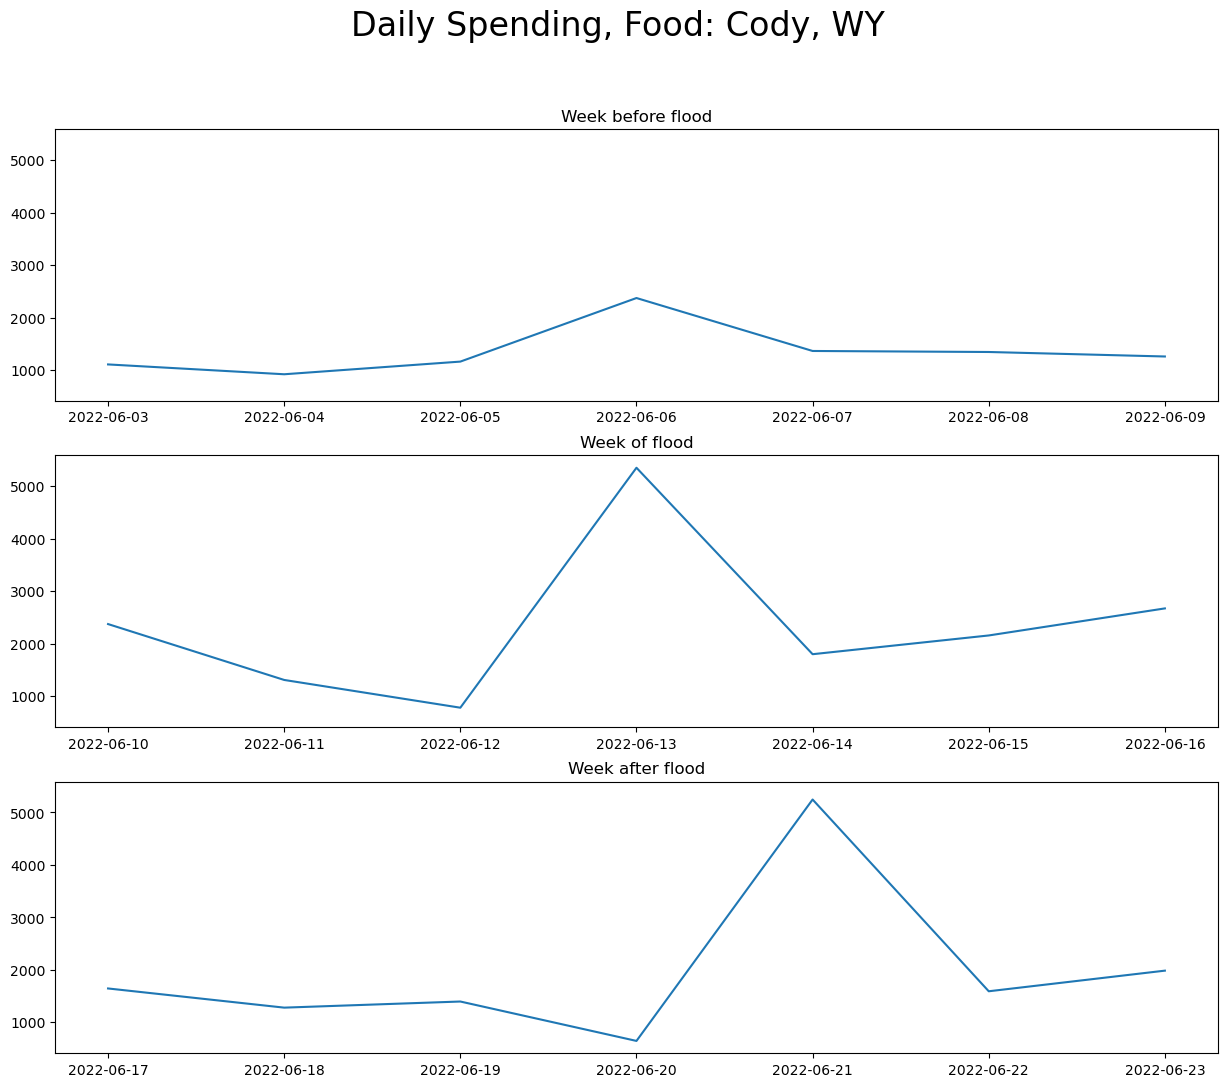

In [63]:
df_food_flood = time_filt(df_cody_food, '2022-05-01', '2022-08-01')
df_flood_spending_food = spend_by_day(df_food_flood)

before_flood_food = df_flood_spending_food[33:40]
during_flood_food = df_flood_spending_food[40:47]
after_flood_food = df_flood_spending_food[47:54]
print(before_flood_food)
print(during_flood_food)
print(after_flood_food)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_food)
ax1.set_title('Week before flood');
ax2.plot(during_flood_food)
ax2.set_title('Week of flood');
ax3.plot(after_flood_food)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Food: Cody, WY', fontsize='24');

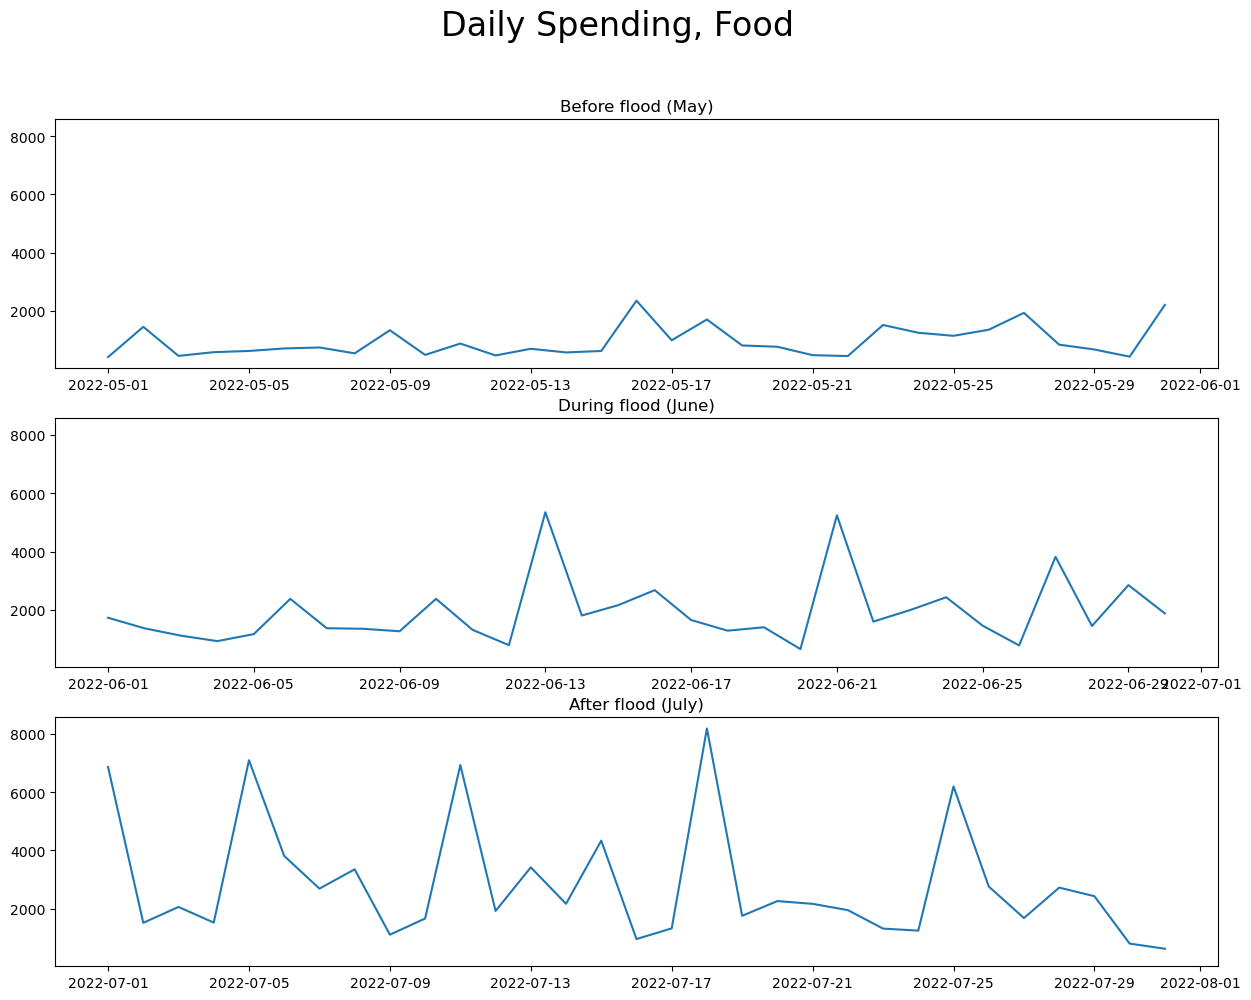

In [41]:
df_spend_before_food = spend_by_day(df_food_before)
df_spend_during_food = spend_by_day(df_food_during)
df_spend_after_food = spend_by_day(df_food_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_food)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_food)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_food)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Food', fontsize='24');

Before Flooding: 
Out of state:  918
In state:  287
Percentage out of state: 76.18257261410788 %


During Flooding: 
Out of state:  1825
In state:  255
Percentage out of state: 87.74038461538461 %


After Flooding: 
Out of state:  1964
In state:  582
Percentage out of state: 77.14061272584446 %




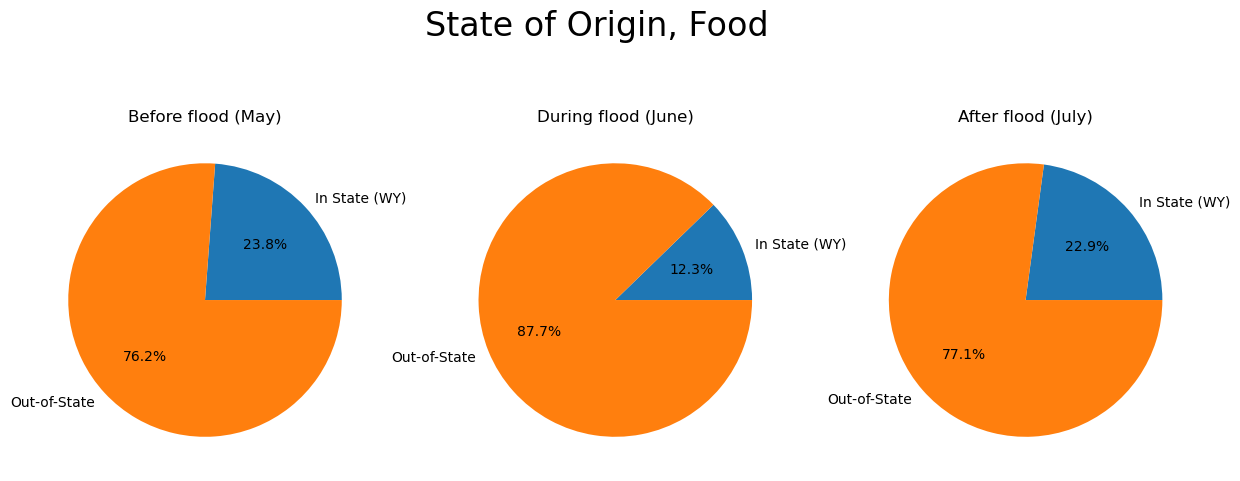

In [42]:
print('Before Flooding: ')
before = percent_instate(df_food_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_food_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_food_after)
print('\n')

labels = 'In State (WY)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Food', fontsize='24');

In [43]:
df_food_jan = time_filt(df_cody_food, month[0], month[1])
df_food_feb = time_filt(df_cody_food, month[1], month[2])
df_food_mar = time_filt(df_cody_food, month[2], month[3])
df_food_apr = time_filt(df_cody_food, month[3], month[4])
df_food_may = time_filt(df_cody_food, month[4], month[5])
df_food_jun = time_filt(df_cody_food, month[5], month[6])
df_food_jul = time_filt(df_cody_food, month[6], month[7])
df_food_aug = time_filt(df_cody_food, month[7], month[8])
df_food_sep = time_filt(df_cody_food, month[8], month[9])
df_food_oct = time_filt(df_cody_food, month[9], month[10])
df_food_nov = time_filt(df_cody_food, month[10], month[11])
df_food_dec = time_filt(df_cody_food, month[11], month[12])

food_dfs = [df_food_jan, df_food_feb, df_food_mar, df_food_apr, df_food_may, df_food_jun, 
             df_food_jul, df_food_aug, df_food_sep, df_food_oct, df_food_nov, df_food_dec]

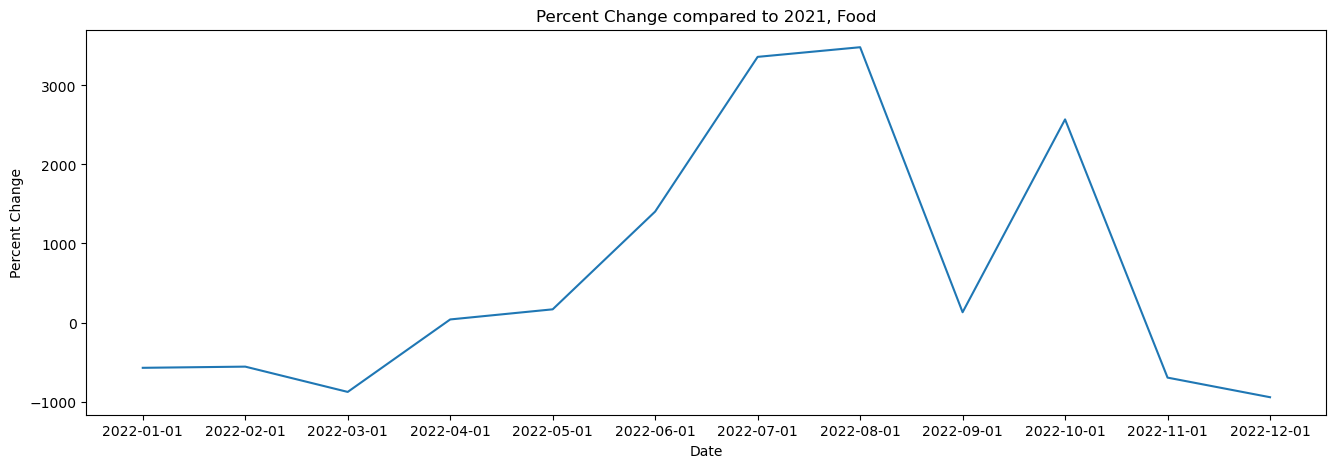

In [44]:
prev_year_pct=[]

for i in range(0, len(food_dfs)):
    prev_year_pct.append(percent_change_year(food_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Food');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

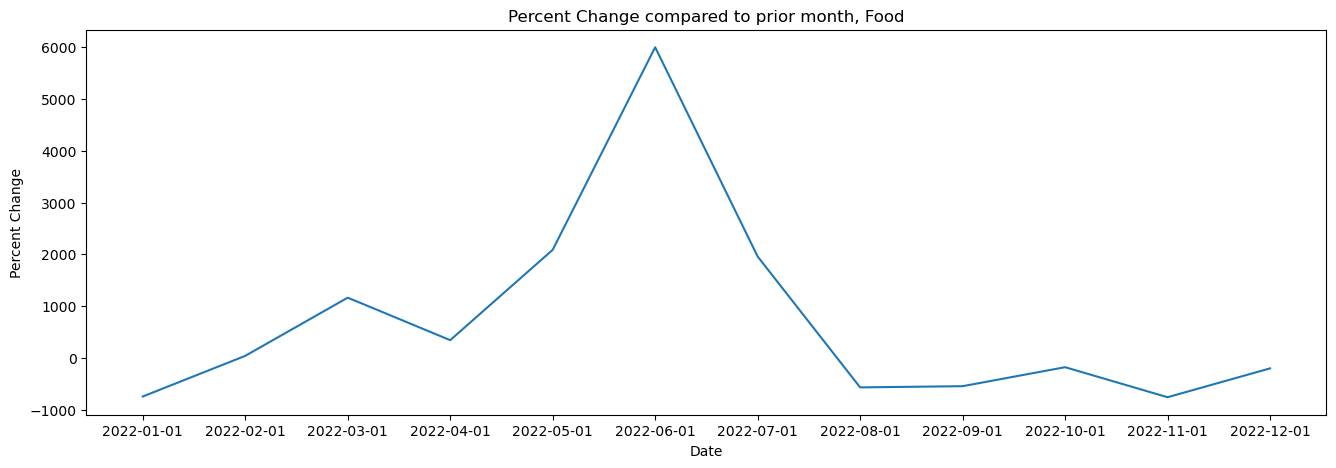

In [45]:
prev_month_pct=[]

for i in range(0, len(food_dfs)):
    prev_month_pct.append(percent_change_month(food_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Food');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Cody Retail

In [46]:
retail_naics = ['452', '445', '451', '448', '446', '711', '712', '713']
combined_mask = np.zeros(len(df_cody_poi),dtype=bool)
for i in retail_naics:
    mask = [ str(ncode)[:3]==i for ncode in list(df_cody_poi['NAICS_CODE']) ]
    combined_mask += mask
df_retail_poi = df_cody_poi[combined_mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_cody_retail = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_retail_poi['PLACEKEY'])]

df_retail_before = time_filt(df_cody_retail, before_flood_start, before_flood_end)
print(df_retail_before.head(5), '\n')

df_retail_during = time_filt(df_cody_retail, during_flood_start, during_flood_end)
print(df_retail_during.head(5), '\n')

df_retail_after = time_filt(df_cody_retail, after_flood_start, after_flood_end)
print(df_retail_after.head(5), '\n')

                   PLACEKEY                        SAFEGRAPH_BRAND_IDS       BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                    BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    RELATE

DATE
2022-06-03     6906.61
2022-06-04     4209.99
2022-06-05     4778.42
2022-06-06    10855.82
2022-06-07     8428.80
2022-06-08    10178.93
2022-06-09     5875.84
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10     7062.76
2022-06-11     4549.74
2022-06-12     4990.53
2022-06-13    17986.34
2022-06-14     9091.65
2022-06-15     7662.75
2022-06-16     7374.11
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17     9526.80
2022-06-18     5173.03
2022-06-19     5780.11
2022-06-20     7781.65
2022-06-21    21327.30
2022-06-22     8178.38
2022-06-23     6080.08
Name: SPEND_BY_DAY, dtype: float64


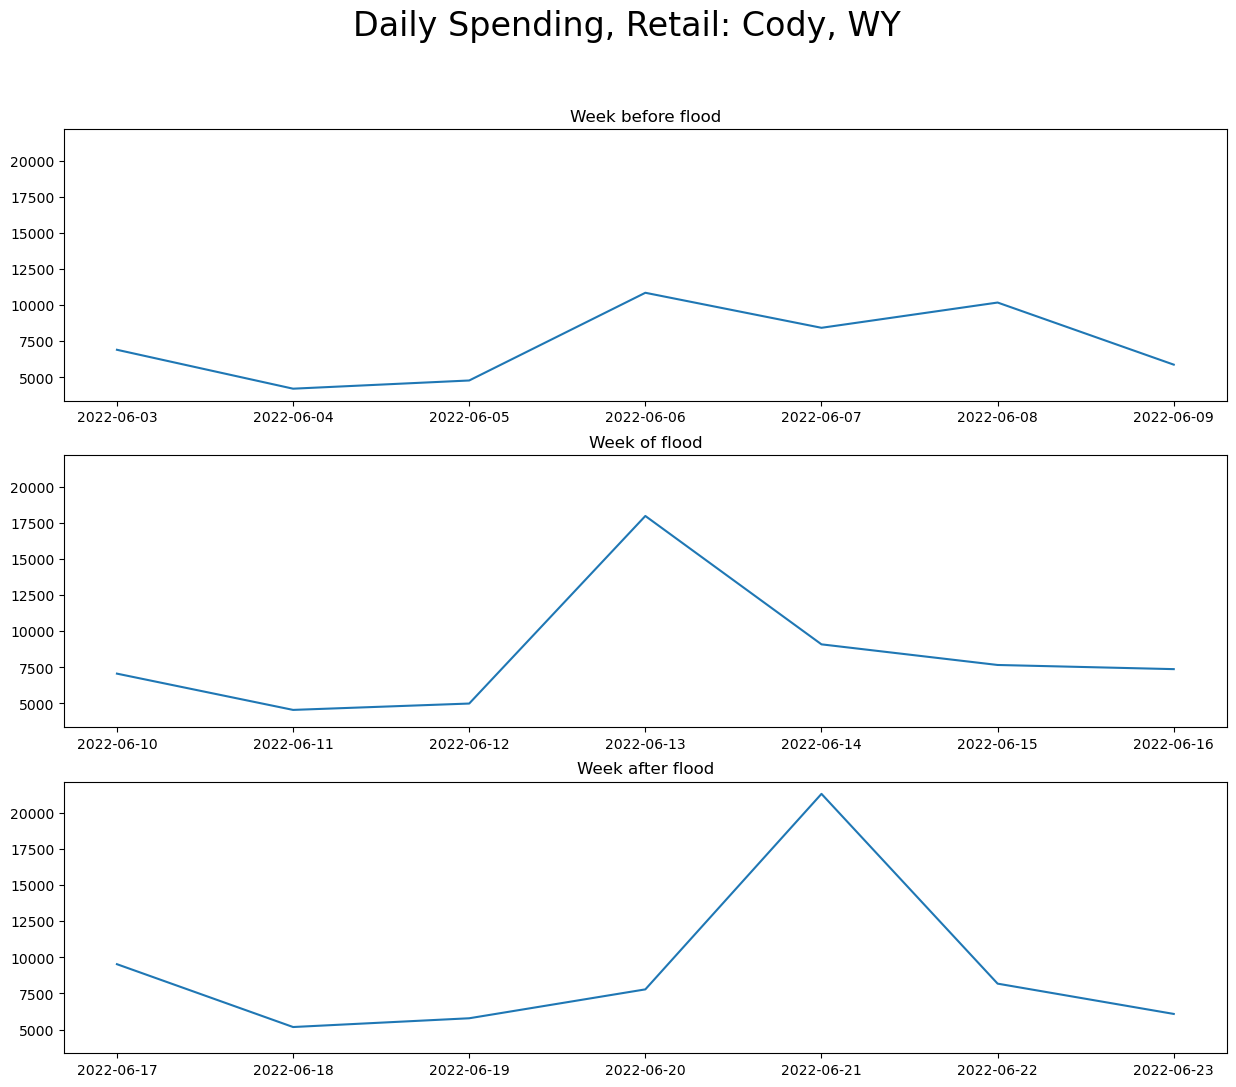

In [64]:
df_retail_flood = time_filt(df_cody_retail, '2022-05-01', '2022-08-01')
df_flood_spending_retail = spend_by_day(df_retail_flood)

before_flood_retail = df_flood_spending_retail[33:40]
during_flood_retail = df_flood_spending_retail[40:47]
after_flood_retail = df_flood_spending_retail[47:54]
print(before_flood_retail)
print(during_flood_retail)
print(after_flood_retail)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_retail)
ax1.set_title('Week before flood');
ax2.plot(during_flood_retail)
ax2.set_title('Week of flood');
ax3.plot(after_flood_retail)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Retail: Cody, WY', fontsize='24');

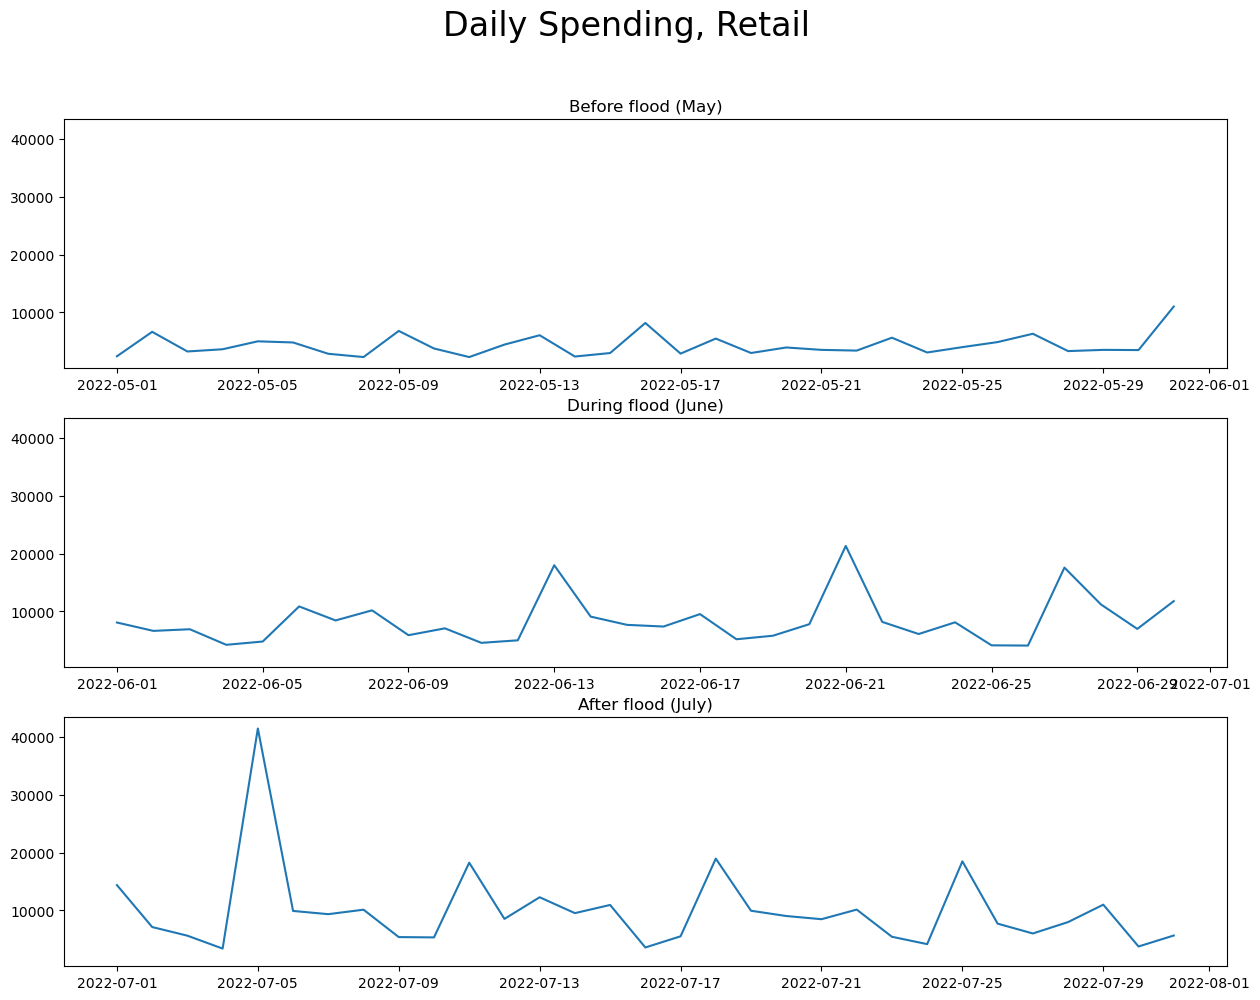

In [48]:
df_spend_before_retail = spend_by_day(df_retail_before)
df_spend_during_retail = spend_by_day(df_retail_during)
df_spend_after_retail = spend_by_day(df_retail_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_retail)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_retail)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_retail)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Retail', fontsize='24');

Before Flooding: 
Out of state:  1149
In state:  279
Percentage out of state: 80.46218487394958 %


During Flooding: 
Out of state:  2330
In state:  325
Percentage out of state: 87.75894538606404 %


After Flooding: 
Out of state:  2630
In state:  750
Percentage out of state: 77.81065088757396 %




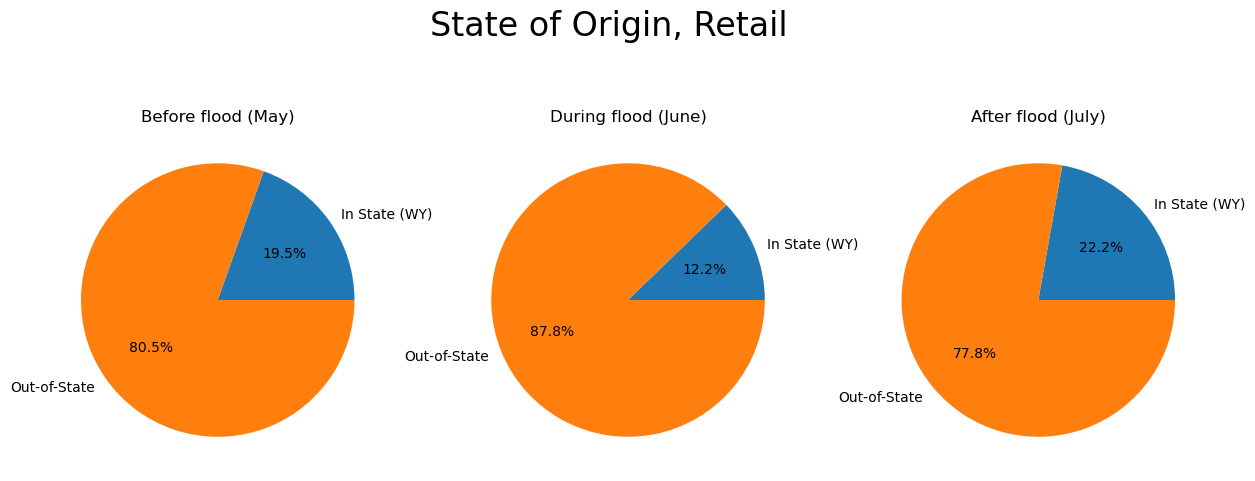

In [49]:
print('Before Flooding: ')
before = percent_instate(df_retail_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_retail_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_retail_after)
print('\n')

labels = 'In State (WY)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Retail', fontsize='24');

In [50]:
df_retail_jan = time_filt(df_cody_retail, month[0], month[1])
df_retail_feb = time_filt(df_cody_retail, month[1], month[2])
df_retail_mar = time_filt(df_cody_retail, month[2], month[3])
df_retail_apr = time_filt(df_cody_retail, month[3], month[4])
df_retail_may = time_filt(df_cody_retail, month[4], month[5])
df_retail_jun = time_filt(df_cody_retail, month[5], month[6])
df_retail_jul = time_filt(df_cody_retail, month[6], month[7])
df_retail_aug = time_filt(df_cody_retail, month[7], month[8])
df_retail_sep = time_filt(df_cody_retail, month[8], month[9])
df_retail_oct = time_filt(df_cody_retail, month[9], month[10])
df_retail_nov = time_filt(df_cody_retail, month[10], month[11])
df_retail_dec = time_filt(df_cody_retail, month[11], month[12])

retail_dfs = [df_retail_jan, df_retail_feb, df_retail_mar, df_retail_apr, df_retail_may, df_retail_jun, 
             df_retail_jul, df_retail_aug, df_retail_sep, df_retail_oct, df_retail_nov, df_retail_dec]

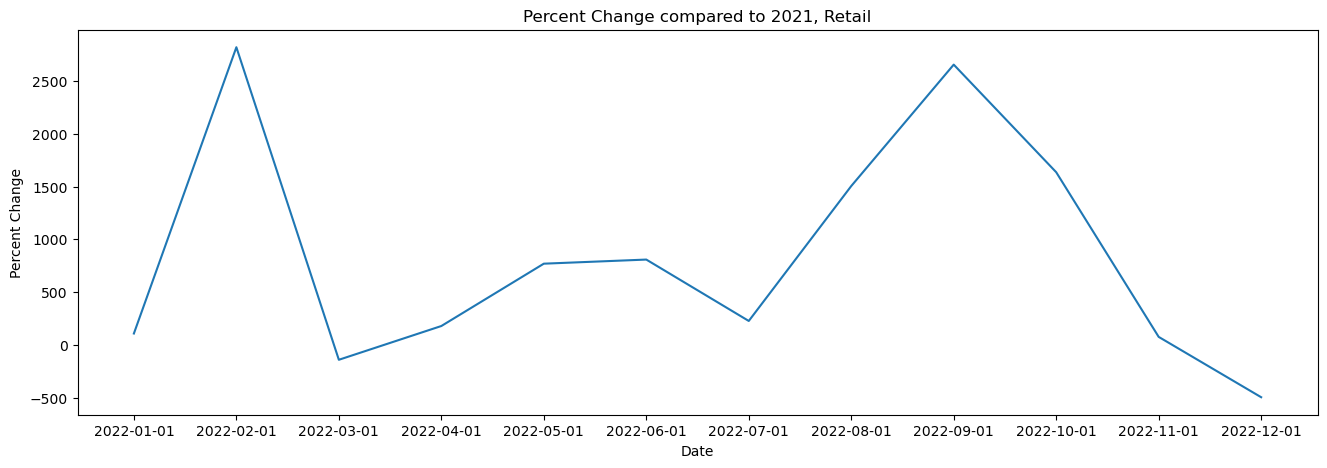

In [51]:
prev_year_pct=[]

for i in range(0, len(retail_dfs)):
    prev_year_pct.append(percent_change_year(retail_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Retail');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

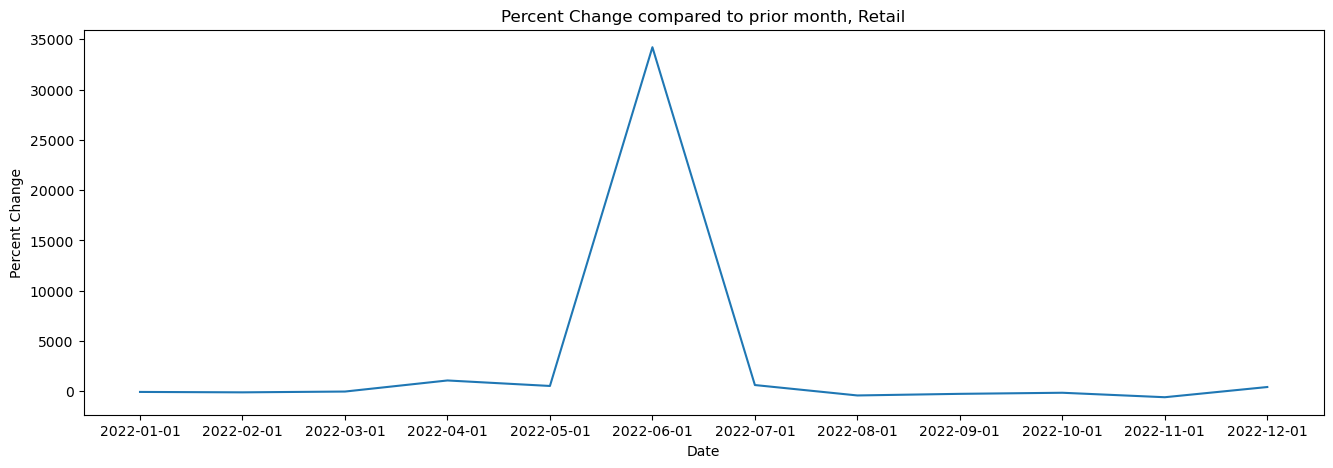

In [52]:
prev_month_pct=[]

for i in range(0, len(retail_dfs)):
    prev_month_pct.append(percent_change_month(retail_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Retail');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Cody Transportation

In [53]:
transit_naics = ['447', '485', '481']
combined_mask = np.zeros(len(df_cody_poi),dtype=bool)
for i in transit_naics:
    mask = [ str(ncode)[:3]==i for ncode in list(df_cody_poi['NAICS_CODE']) ]
    combined_mask += mask
df_transit_poi = df_cody_poi[combined_mask]

if 'PLACEKEY' in df_safegraph_spend.columns:
    df_cody_transit = df_safegraph_spend[df_safegraph_spend['PLACEKEY'].isin(df_transit_poi['PLACEKEY'])]

df_transit_before = time_filt(df_cody_transit, before_flood_start, before_flood_end)
print(df_transit_before.head(5), '\n')

df_transit_during = time_filt(df_cody_transit, during_flood_start, during_flood_end)
print(df_transit_during.head(5), '\n')

df_transit_after = time_filt(df_cody_transit, after_flood_start, after_flood_end)
print(df_transit_after.head(5), '\n')

                   PLACEKEY                        SAFEGRAPH_BRAND_IDS            BRANDS SPEND_DATE_RANGE_START SPEND_DATE_RANGE_END  RAW_TOTAL_SPEND  RAW_NUM_TRANSACTIONS  RAW_NUM_CUSTOMERS  MEDIAN_SPEND_PER_TRANSACTION  MEDIAN_SPEND_PER_CUSTOMER SPEND_PER_TRANSACTION_PERCENTILES                                       SPEND_BY_DAY                       SPEND_PER_TRANSACTION_BY_DAY                               SPEND_BY_DAY_OF_WEEK                                         DAY_COUNTS  SPEND_PCT_CHANGE_VS_PREV_MONTH  SPEND_PCT_CHANGE_VS_PREV_YEAR  ONLINE_TRANSACTIONS  ONLINE_SPEND TRANSACTION_INTERMEDIARY SPEND_BY_TRANSACTION_INTERMEDIARY                  BUCKETED_CUSTOMER_FREQUENCY               MEAN_SPEND_PER_CUSTOMER_BY_FREQUENCY                          BUCKETED_CUSTOMER_INCOMES                  MEAN_SPEND_PER_CUSTOMER_BY_INCOME                                 CUSTOMER_HOME_CITY         RELATED_CROSS_SHOPPING_PHYSICAL_BRANDS_PCT        RELATED_CROSS_SHOPPING_ONLINE_MERCHANTS_PCT    REL

DATE
2022-06-03     43.68
2022-06-04    386.86
2022-06-05    366.72
2022-06-06    257.07
2022-06-07    292.56
2022-06-08    152.81
2022-06-09    511.09
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-10    616.47
2022-06-11    271.61
2022-06-12     13.83
2022-06-13    625.53
2022-06-14    185.69
2022-06-15    324.04
2022-06-16    168.71
Name: SPEND_BY_DAY, dtype: float64
DATE
2022-06-17     85.11
2022-06-18    236.43
2022-06-19    344.72
2022-06-20    132.80
2022-06-21    949.51
2022-06-22    363.96
2022-06-23    370.04
Name: SPEND_BY_DAY, dtype: float64


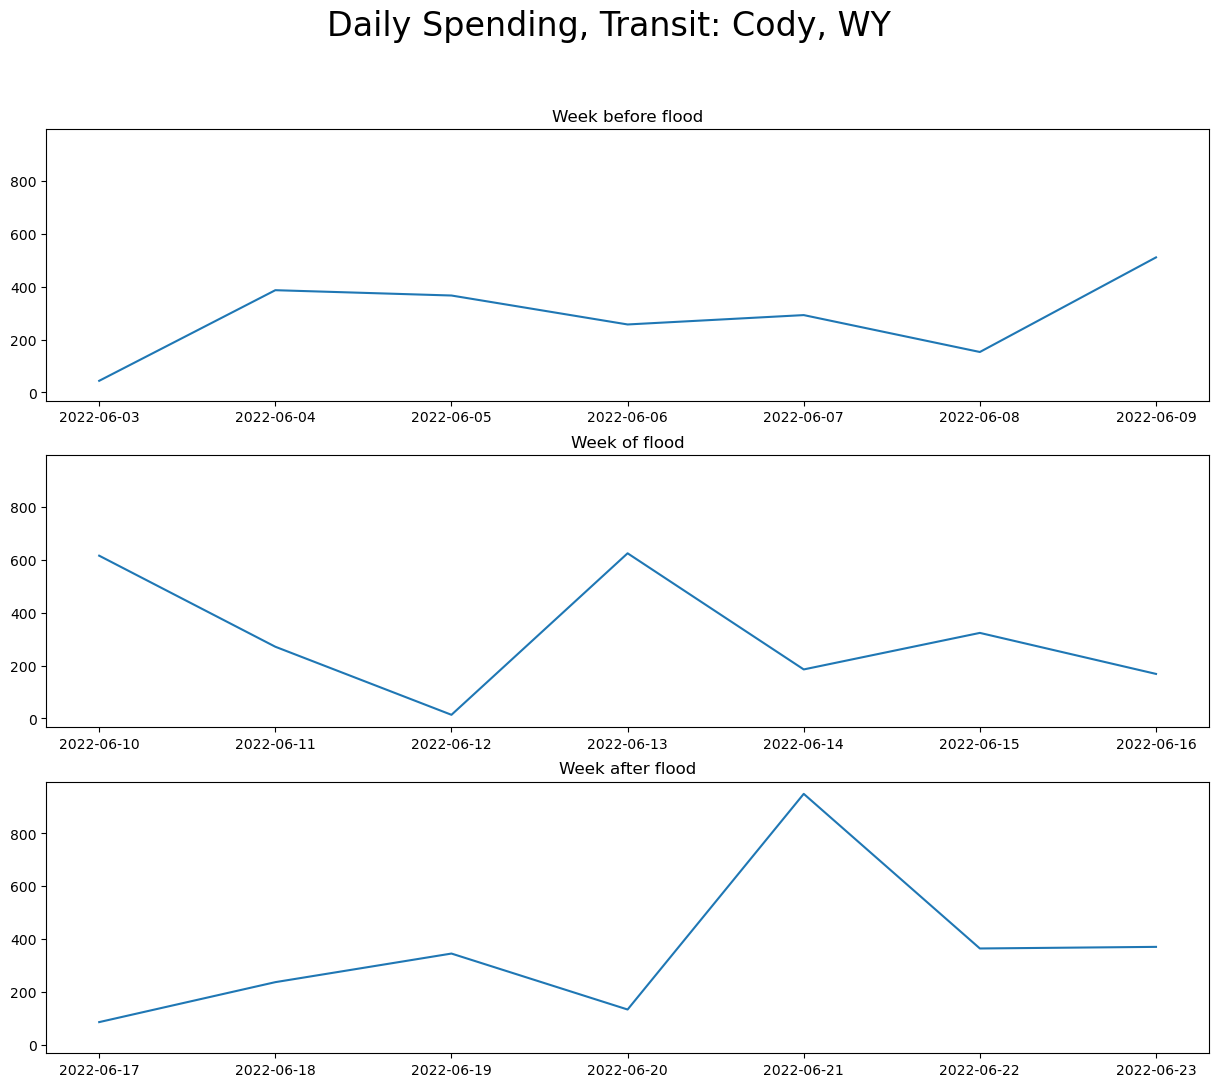

In [65]:
df_transit_flood = time_filt(df_cody_transit, '2022-05-01', '2022-08-01')
df_flood_spending_transit = spend_by_day(df_transit_flood)

before_flood_transit = df_flood_spending_transit[33:40]
during_flood_transit = df_flood_spending_transit[40:47]
after_flood_transit = df_flood_spending_transit[47:54]
print(before_flood_transit)
print(during_flood_transit)
print(after_flood_transit)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 12), sharey=True);
ax1.plot(before_flood_transit)
ax1.set_title('Week before flood');
ax2.plot(during_flood_transit)
ax2.set_title('Week of flood');
ax3.plot(after_flood_transit)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending, Transit: Cody, WY', fontsize='24');

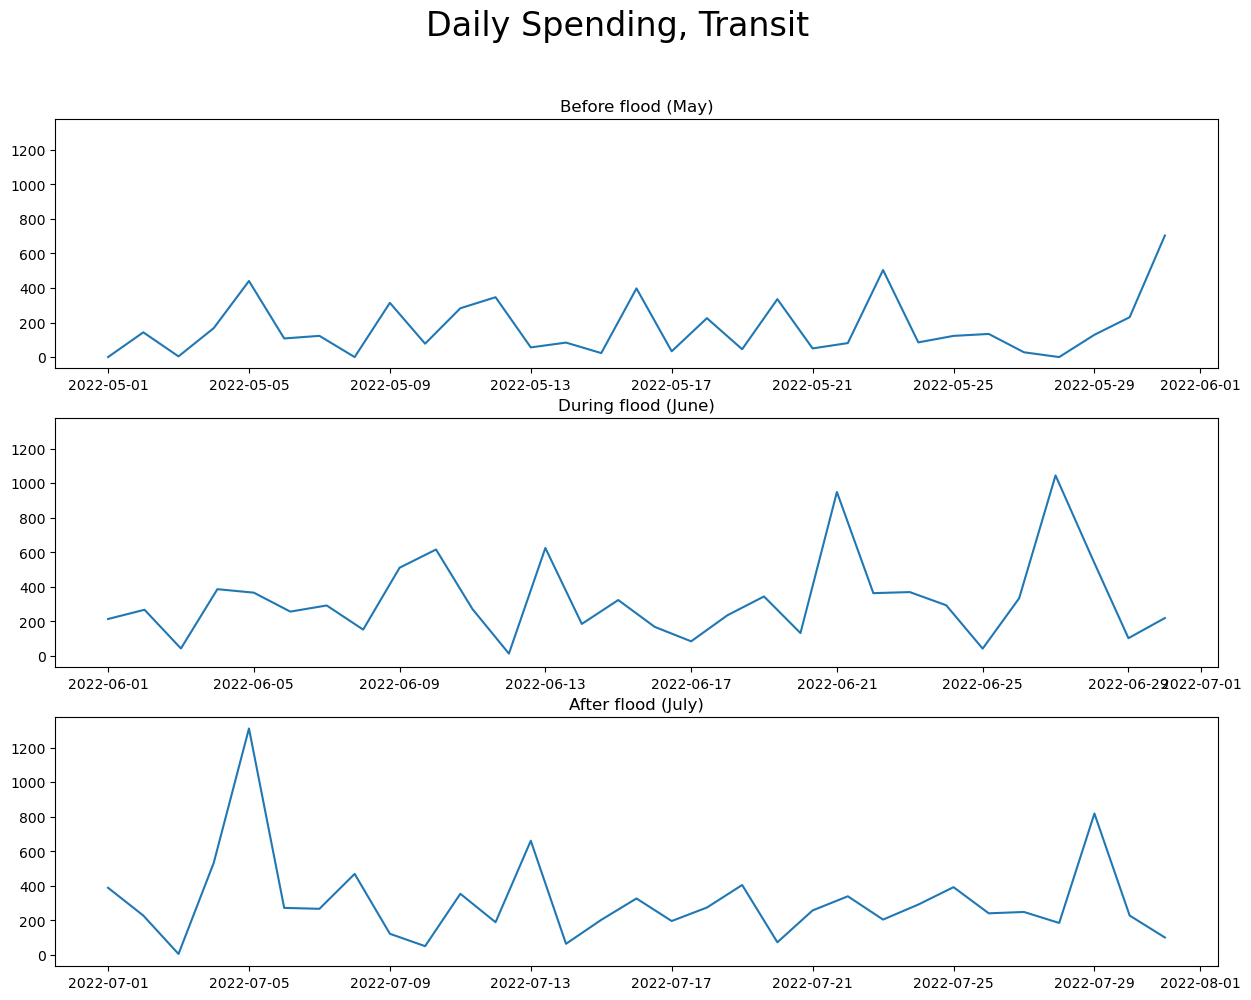

In [55]:
df_spend_before_transit = spend_by_day(df_transit_before)
df_spend_during_transit = spend_by_day(df_transit_during)
df_spend_after_transit = spend_by_day(df_transit_after)

fig, (ax1, ax2, ax3) = subplots(3, 1, figsize=(15, 11), sharey=True);
ax1.plot(df_spend_before_transit)
ax1.set_title('Before flood (May)');
ax2.plot(df_spend_during_transit)
ax2.set_title('During flood (June)');
ax3.plot(df_spend_after_transit)
ax3.set_title('After flood (July)');

fig.suptitle('Daily Spending, Transit', fontsize='24');

Before Flooding: 
Out of state:  98
In state:  32
Percentage out of state: 75.38461538461539 %


During Flooding: 
Out of state:  238
In state:  27
Percentage out of state: 89.81132075471699 %


After Flooding: 
Out of state:  191
In state:  51
Percentage out of state: 78.92561983471074 %




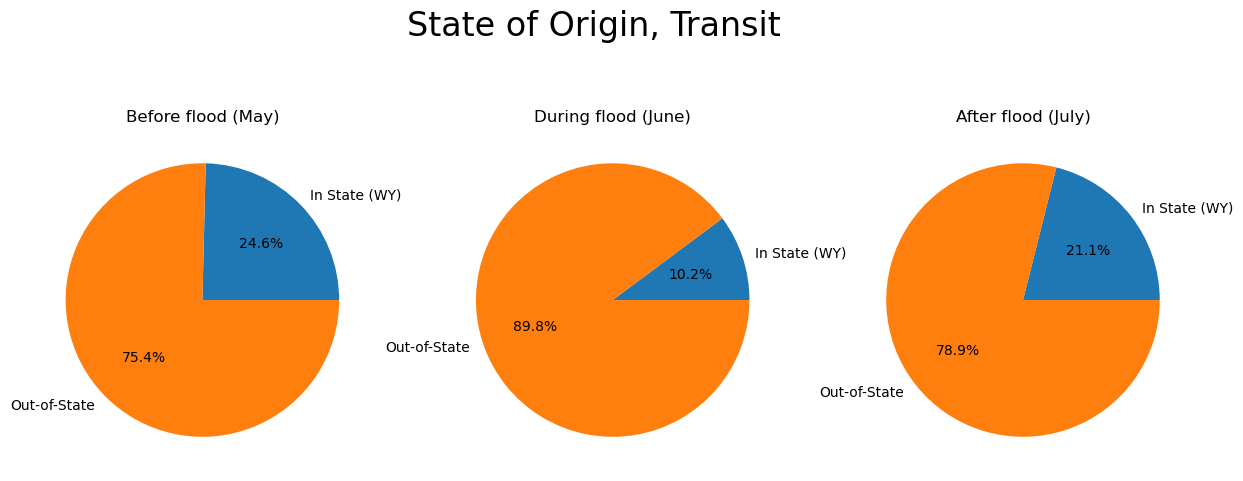

In [57]:
print('Before Flooding: ')
before = percent_instate(df_transit_before)
print('\n')

print('During Flooding: ')
during = percent_instate(df_transit_during)
print('\n')

print('After Flooding: ')
after = percent_instate(df_transit_after)
print('\n')

labels = 'In State (WY)','Out-of-State'
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 6));

ax1.pie(before, labels=labels, autopct='%1.1f%%');
ax1.set_title('Before flood (May)');
ax2.pie(during, labels=labels, autopct='%1.1f%%');
ax2.set_title('During flood (June)');
ax3.pie(after, labels=labels, autopct='%1.1f%%');
ax3.set_title('After flood (July)');
fig.suptitle('State of Origin, Transit', fontsize='24');

In [58]:
df_transit_jan = time_filt(df_cody_transit, month[0], month[1])
df_transit_feb = time_filt(df_cody_transit, month[1], month[2])
df_transit_mar = time_filt(df_cody_transit, month[2], month[3])
df_transit_apr = time_filt(df_cody_transit, month[3], month[4])
df_transit_may = time_filt(df_cody_transit, month[4], month[5])
df_transit_jun = time_filt(df_cody_transit, month[5], month[6])
df_transit_jul = time_filt(df_cody_transit, month[6], month[7])
df_transit_aug = time_filt(df_cody_transit, month[7], month[8])
df_transit_sep = time_filt(df_cody_transit, month[8], month[9])
df_transit_oct = time_filt(df_cody_transit, month[9], month[10])
df_transit_nov = time_filt(df_cody_transit, month[10], month[11])
df_transit_dec = time_filt(df_cody_transit, month[11], month[12])

transit_dfs = [df_transit_jan, df_transit_feb, df_transit_mar, df_transit_apr, df_transit_may, df_transit_jun, 
             df_transit_jul, df_transit_aug, df_transit_sep, df_transit_oct, df_transit_nov, df_transit_dec]

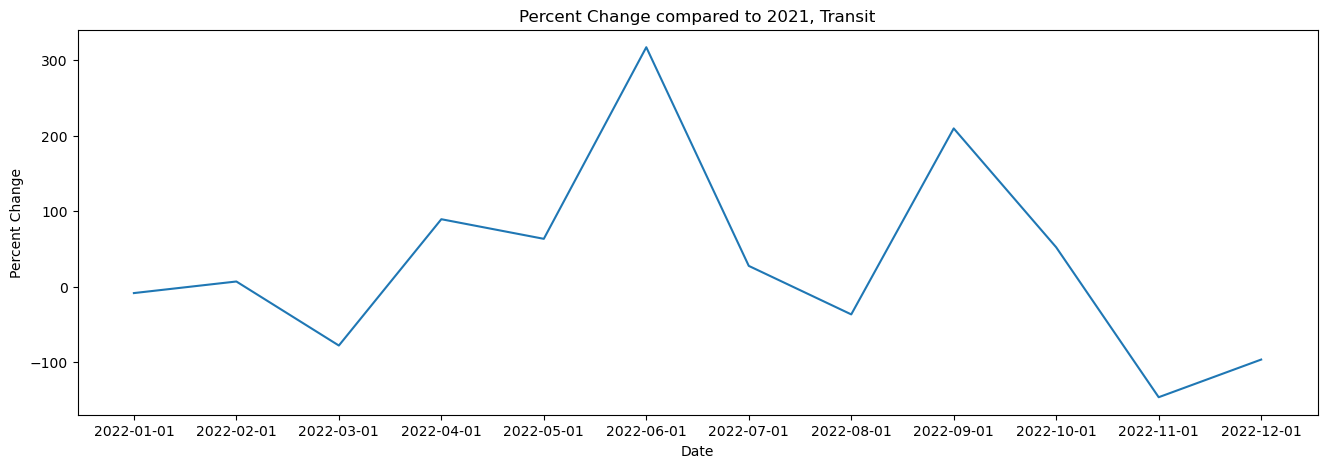

In [59]:
prev_year_pct=[]

for i in range(0, len(transit_dfs)):
    prev_year_pct.append(percent_change_year(transit_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_year_pct);
ax.set_title('Percent Change compared to 2021, Transit');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

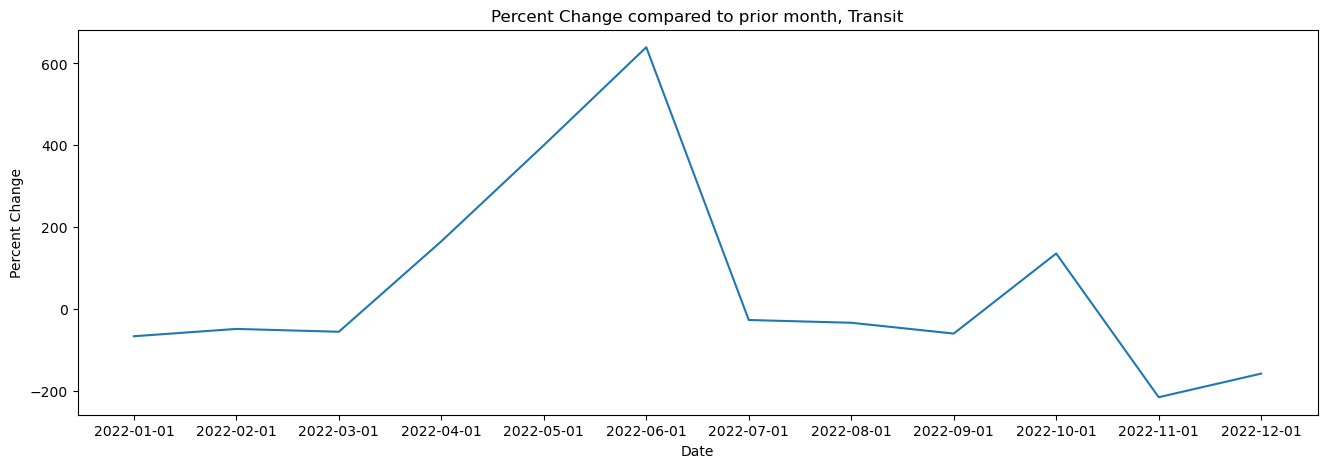

In [60]:
prev_month_pct=[]

for i in range(0, len(transit_dfs)):
    prev_month_pct.append(percent_change_month(transit_dfs[i]))

fig, ax = subplots(figsize=(16, 5))
ax.plot(month[0:12], prev_month_pct);
ax.set_title('Percent Change compared to prior month, Transit');
ax.set_xlabel('Date');
ax.set_ylabel('Percent Change');

## Aggregate 

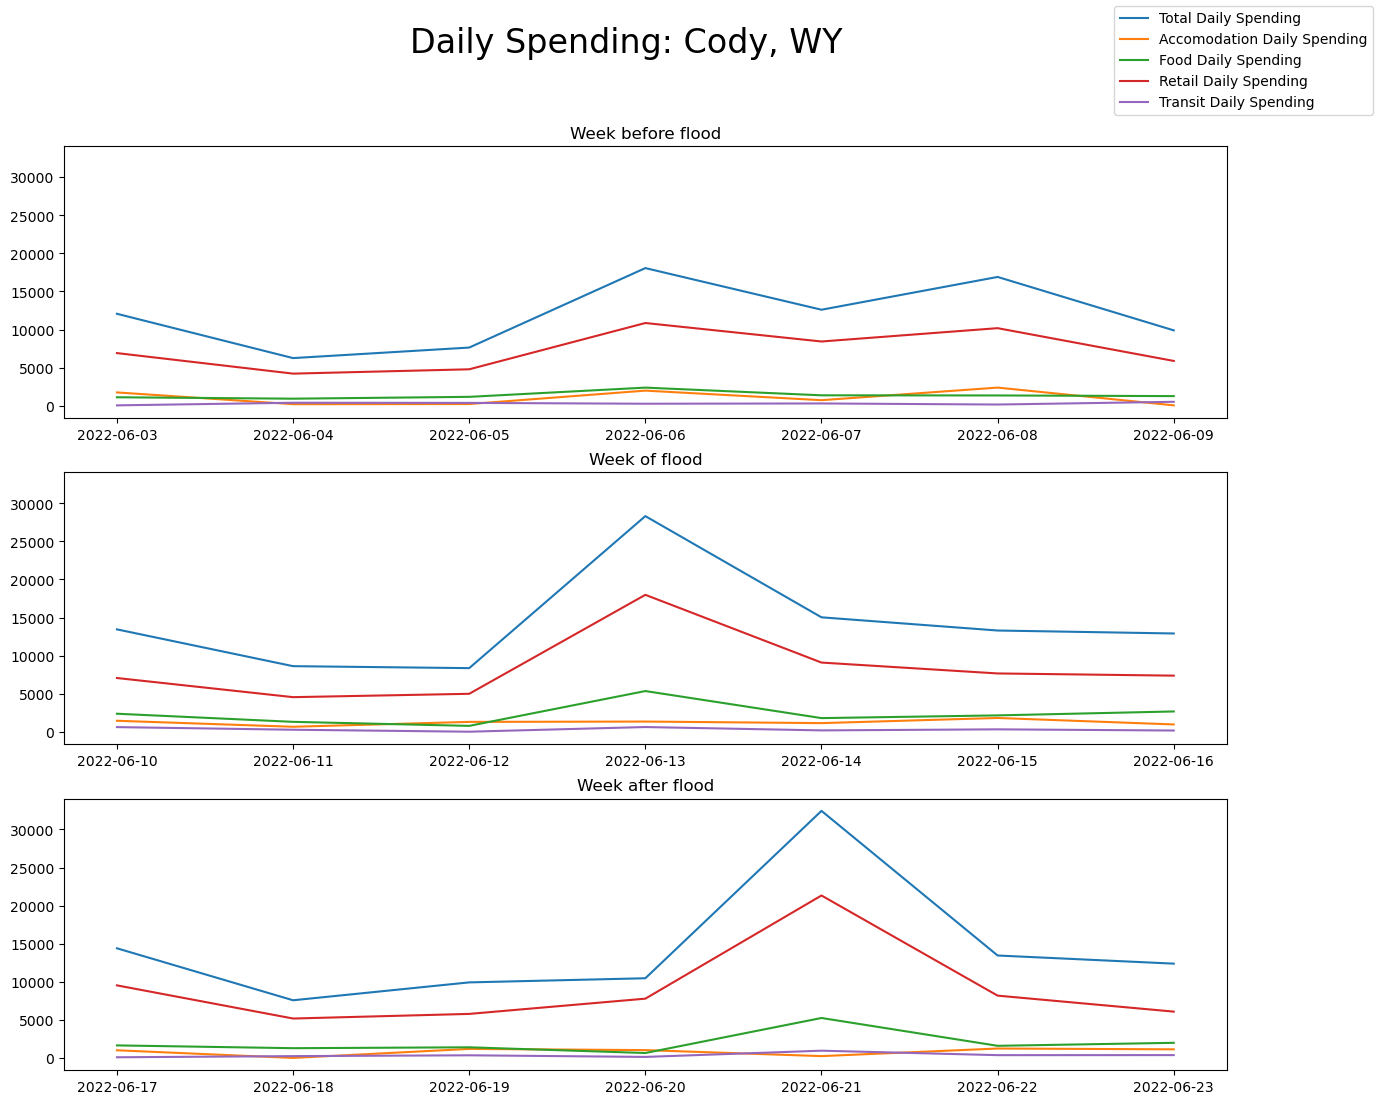

In [ ]:
fig, (ax1, ax2, ax3) = subplots(1, 3, figsize=(15, 12), sharey=True);
ax1.plot(before_flood, label='Total Daily Spending')
ax1.plot(before_flood_hotels, label='Accomodation Daily Spending');
ax1.plot(before_flood_food, label='Food Daily Spending')
ax1.plot(before_flood_retail, label='Retail Daily Spending')
ax1.plot(before_flood_transit, label='Transit Daily Spending')
ax1.set_title('Week before flood');
ax2.plot(during_flood)
ax2.plot(during_flood_hotels)
ax2.plot(during_flood_food)
ax2.plot(during_flood_retail)
ax2.plot(during_flood_transit)
ax2.set_title('Week of flood');
ax3.plot(after_flood)
ax3.plot(after_flood_hotels)
ax3.plot(after_flood_food)
ax3.plot(after_flood_retail)
ax3.plot(after_flood_transit)
ax3.set_title('Week after flood');
fig.suptitle('Daily Spending: Cody, WY', fontsize='24');
fig.legend();